# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2025)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">Tutorial 3c: Convolutional Neural Network with MiniVGG</span><span style="color:red;  font-size: 18px">***** (highly important)</span> #
**This tutorial applies CNN to a more real-world setting using TensorFlow using the `CIFAR-10` dataset. It will cover the following**:
1. ***How to implement a simplified version of a real-world CNN named `MiniVGG` to classify the `CIFAR-10` dataset using PyTorch***.
2. ***How to augment the data for training our MiniVGG***.
3. ***How to visualize the filters and feature maps of CNNs (optional reading)***.

VGGNet, (aka VGG), was first introduced by Simonyan and Zisserman in their 2014 paper, *Very Deep Learning Convolutional Neural Networks for Large-Scale Image Recognition*.
The work was the first to demonstrate that architecture with very small (3×3) filters can be successfully trained for very deep networks (16-19 layers) and obtain state-of-the-art classification on the challenging ImageNet classification challenge. <br/>

The VGG family of Convolutional Neural Networks can be characterized by two key components:
1. *All CONV layers in the network using only **3×3** filters.*
2. *Stacking multiple CONV => RELU layer sets (where the number of consecutive CONV => RELU layers normally increases as we go deeper) before applying a POOL operation.* <br/>

Due to the size of this architecture which compromises the running time, this tutorial will use `MiniVGG` which is a simplified version of `VGG` including its architecture, implementation, and application to the `CIFAR-10` dataset.

---

## <span style="color:#0b486b">I. MiniVGG for the CIFAR-10 dataset</span> ##

### <span style="color:#0b486b">I.1. Architecture of MiniVGG </span>
The following figure and table show the concrete architecture of `MiniVGG`. As mentioned before, `MiniVGG` only uses $3\times3$ filters. In addition, in the `MiniVGGNet`, we apply the batch norm technique to regularize the training and allow the network to be trained with a higher learning rate.

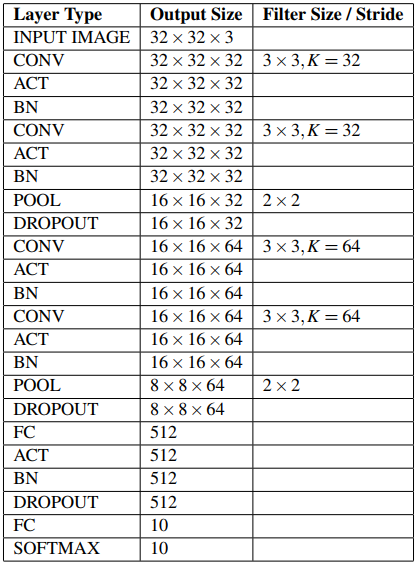

### <span style="color:#0b486b">I.2. Implementation of MiniVGG </span>

#### <span style="color:#0b486b">I.2.1 Import necessary packages and modules </span>

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [ ]:
np.random.seed(123)
torch.manual_seed(123)

#### <span style="color:#0b486b">I.2.2 Download, prepare and preprocess CIFAR-10 dataset </span>

The CIFAR-10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

**We also apply some data augmentations when processing the data**.

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                     transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                     ])

train_transform = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])

full_train_set = torchvision.datasets.CIFAR10("./data", download=True, transform=train_transform)     # Apply train_transform to train set
full_valid_set = torchvision.datasets.CIFAR10("./data", download=True, transform=test_transform)      # Apply test_transform to generate valid set
full_test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=test_transform)

n_train, n_valid, n_test = 5000, 5000, 5000

total_num_train = len(full_train_set)
total_num_test = len(full_test_set)
train_valid_idx = torch.randperm(total_num_train)
train_set = torch.utils.data.Subset(full_train_set, train_valid_idx[:n_train])
valid_set = torch.utils.data.Subset(full_valid_set, train_valid_idx[n_train:n_train+n_valid])

test_idx = torch.randperm(total_num_test)
test_set = torch.utils.data.Subset(full_test_set, test_idx[:n_test])

print("Traing set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(train_set), list(train_set[0][0].shape)))
print("Valid set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(valid_set), list(valid_set[0][0].shape)))
print("Test set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(test_set), list(test_set[0][0].shape)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32)

img_train = [train_set[idx][0].numpy().transpose((1,2,0)) for idx in range(32)]
label_train = [train_set[idx][1] for idx in range(32)]

100%|██████████| 170498071/170498071 [00:04<00:00, 42152343.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Traing set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]
Valid set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]
Test set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]


In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [ ]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

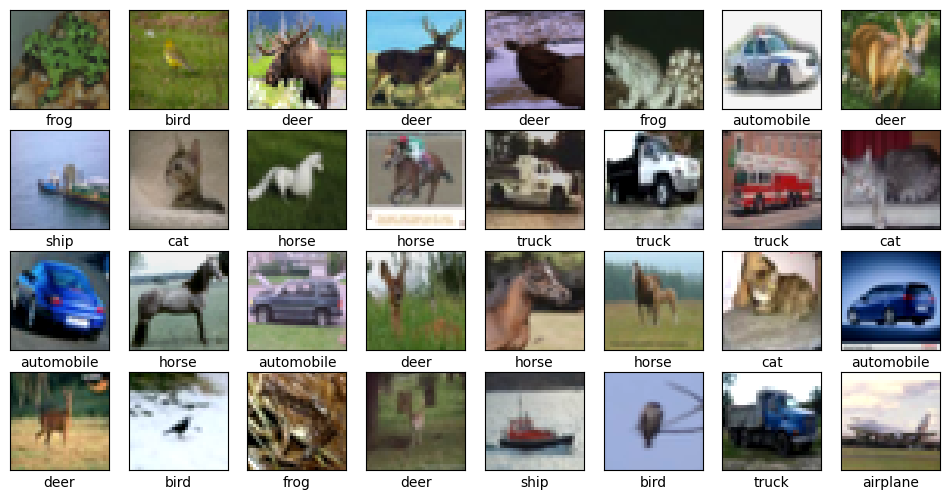

In [ ]:
visualize_data(images, labels)

In [ ]:
def create_vgg():
    vgg_model = nn.Sequential(
        #nn.LazyConv2d(32, kernel_size=3, padding=1),
        nn.Conv2d(3, 32, kernel_size=3, padding= 1), #[32,32,32]
        nn.BatchNorm2d(32),
        nn.ReLU(),
        #nn.LazyConv2d(32, kernel_size=3, padding=1),
        nn.Conv2d(32, 32, kernel_size=3, padding= 1), #[32,32,32]
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), #down-sample by two #[32,16,16]
        nn.Dropout(p=0.25),

        #nn.LazyConv2d(64, kernel_size=3, padding=1),
        nn.Conv2d(32, 64 , kernel_size=3, padding= 1), #[64,16,16]
        nn.BatchNorm2d(64),
        nn.ReLU(),
        #nn.LazyConv2d(64, kernel_size=3, padding=1)
        nn.Conv2d(64, 64, kernel_size=3, padding= 1), #[64,16,16]
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.LazyConv2d(64, kernel_size=3, padding= 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), #down-sample by two [64,8,8]
        nn.Dropout(p=0.25),

        nn.Flatten(1), #64x8x8
        #nn.LazyLinear(512),
        nn.Linear(64*8*8, 512), #512
        nn.BatchNorm1d(512),
        nn.ReLU(),
        #nn.LazyLinear(10)
        nn.Linear(512, 10),
      )
    return vgg_model

In [ ]:
aug_vgg_net = create_vgg()

aug_vgg_net = aug_vgg_net.to(device)
print(aug_vgg_net)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_vgg_net.parameters(), lr=learning_rate)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
      model.train()
      model.train() #Set the model back to the training mode
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

We train the model with augmented data in `30` epochs.

In [ ]:
aug_history = fit(model= aug_vgg_net, train_loader=train_loader, valid_loader = valid_loader,
    optimizer = optimizer, num_epochs= 30, verbose = False)

Epoch 1/30
train loss= 1.6927 - train acc= 39.98% - valid loss= 1.7025 - valid acc= 38.80%
Epoch 2/30
train loss= 1.1737 - train acc= 57.50% - valid loss= 1.2959 - valid acc= 52.80%
Epoch 3/30
train loss= 1.1842 - train acc= 58.24% - valid loss= 1.3485 - valid acc= 52.78%
Epoch 4/30
train loss= 0.9813 - train acc= 65.04% - valid loss= 1.1911 - valid acc= 57.08%
Epoch 5/30
train loss= 0.7550 - train acc= 74.00% - valid loss= 1.0198 - valid acc= 63.98%
Epoch 6/30
train loss= 0.6415 - train acc= 77.56% - valid loss= 0.9639 - valid acc= 66.68%
Epoch 7/30
train loss= 0.5640 - train acc= 80.52% - valid loss= 0.9516 - valid acc= 67.08%
Epoch 8/30
train loss= 0.5237 - train acc= 83.50% - valid loss= 0.9398 - valid acc= 67.18%
Epoch 9/30
train loss= 0.5334 - train acc= 82.04% - valid loss= 0.9887 - valid acc= 67.10%
Epoch 10/30
train loss= 0.3800 - train acc= 88.20% - valid loss= 0.9334 - valid acc= 68.78%
Epoch 11/30
train loss= 0.4587 - train acc= 84.94% - valid loss= 1.0827 - valid acc= 64.1

We can observe an improvement when evaluating on the testing set comparing to the case of without augmentations.

In [ ]:
test_acc = compute_acc(model = aug_vgg_net, loader= test_loader)
print(f"Test acc = {test_acc*100:.2f}%")

Test acc = 71.26%


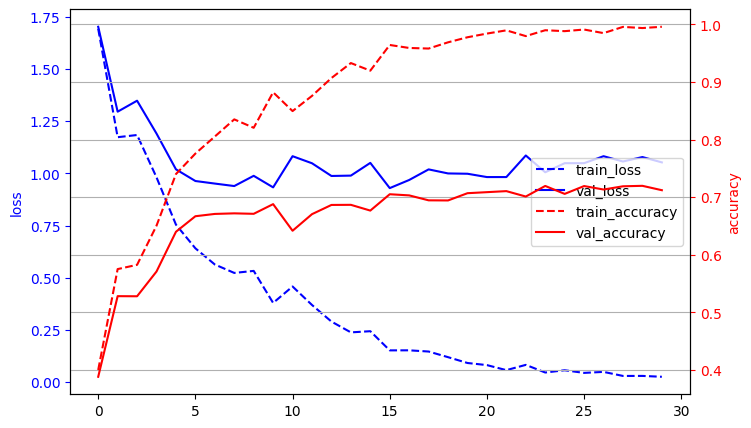

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = aug_history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='train_accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

**<span style="color:red">Discussion 3</span>:** Comparing the training curves of with and without augmentations, what are your observations and conclusions?

## <span style="color:#0b486b">II. Visualize filters and feature maps of CNN</span> ##

Visualizing the filters and feature maps is important to help us understand what is learned by trained CNNs. We expect that low layers can capture low-level features such as edges, pixels, and corners, middle layers can capture mid-level features such as circles, boxes, triangles, while high layers can capture high-level features such as objects. According to the operational principle of CNNs, features captured by higher layers are a combination of those in lower layers. For example, edges combine into boxes, and boxes and triangles, in turn, combine into more complicated objects.

We now explore how to visualize the filters and feature maps for our trained MiniVGG network.

We first play around with how to get all layers in a PyTorch model and how to extract information from a specific layer.

In [ ]:
import torch.nn as nn

for i, (name, layer) in enumerate(aug_vgg_net.named_modules()):
    if isinstance(layer, nn.Module):  # Check if the item is a layer
        print("Layer {}: {}".format(i, layer.__class__.__name__))

Layer 0: Sequential
Layer 1: Conv2d
Layer 2: BatchNorm2d
Layer 3: ReLU
Layer 4: Conv2d
Layer 5: BatchNorm2d
Layer 6: ReLU
Layer 7: MaxPool2d
Layer 8: Dropout
Layer 9: Conv2d
Layer 10: BatchNorm2d
Layer 11: ReLU
Layer 12: Conv2d
Layer 13: BatchNorm2d
Layer 14: ReLU
Layer 15: Conv2d
Layer 16: BatchNorm2d
Layer 17: ReLU
Layer 18: MaxPool2d
Layer 19: Dropout
Layer 20: Flatten
Layer 21: Linear
Layer 22: ReLU
Layer 23: Linear


In what follows, we examine all Conv2D layers in our network and print out their filters. Recall that the set of filters is represented as a $4D$ tensor with the shape $[num\_filters, fil\_depth, fil\_height, fil\_width]$.

In [ ]:
for l_idx, (name, layer) in enumerate(aug_vgg_net.named_modules()):
    if isinstance(layer, torch.nn.Conv2d):
        print("Layer {} name: {}, shape: [{}, {}]".format(l_idx, layer.__class__.__name__, layer.out_channels, layer.kernel_size))
        print(list(layer.weight.shape))

Layer 1 name: Conv2d, shape: [32, (3, 3)]
[32, 3, 3, 3]
Layer 4 name: Conv2d, shape: [32, (3, 3)]
[32, 32, 3, 3]
Layer 9 name: Conv2d, shape: [64, (3, 3)]
[64, 32, 3, 3]
Layer 12 name: Conv2d, shape: [64, (3, 3)]
[64, 64, 3, 3]
Layer 15 name: Conv2d, shape: [64, (3, 3)]
[64, 64, 3, 3]


We now visualize a filter in a Conv2D layer of a specific model. Note that each filter is a 3D tensor with shape $[fil\_height, fil\_width, fil\_depth]$.

In [ ]:
def visualize_filter(model, layer_index=0, n_cols=8, filter_index=0):
    # Find the specified layer in the model
    layer = model[layer_index]
    assert isinstance(layer, torch.nn.Conv2d), "The current layer is not a Conv2D layer"
    filters = layer.weight.data.cpu().numpy()  # 4D tensor of all filters [num_filters, fil_depth, fil_height, fil_width]
    n_filters = filters[filter_index].shape[0]  # get the number of filters to later visualize each of them
    print(filters.shape)
    n_rows = math.ceil(n_filters / n_cols)
    fig = plt.figure(figsize=(n_cols, n_rows))
    plt.axis("off")

    for i in range(n_filters):
        plt.subplot(n_rows, n_cols, i + 1)
        filter_img = filters[filter_index, i, :, :]  # get the i-th filter
        # normalize the filter values to 0-1 range for display
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
        # rearrange the filter dimensions for visualization
        if filter_img.ndim == 3:  # if the filter has 3 channels (RGB)
            filter_img = np.transpose(filter_img, (1, 2, 0))
        plt.imshow(filter_img)
        plt.xlabel(f"Filter {i}")
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    fig.tight_layout()
    plt.show()

We visualize the 5th filter in the filters of the convolutional layer ReLU (Layer 3)
(32, 32, 3, 3)


<ipython-input-24-c85bf121bb61>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


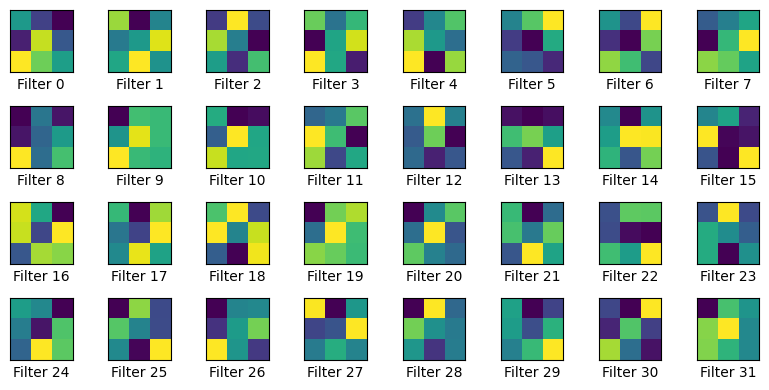

In [ ]:
print("We visualize the 5th filter in the filters of the convolutional layer {} (Layer 3)".format(layer_name))
visualize_filter(aug_vgg_net, layer_index=3, filter_index=5)

We visualize the 5th filter in the filters of the convolutional layer Conv2d (Layer 8)
(64, 32, 3, 3)


<ipython-input-24-c85bf121bb61>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


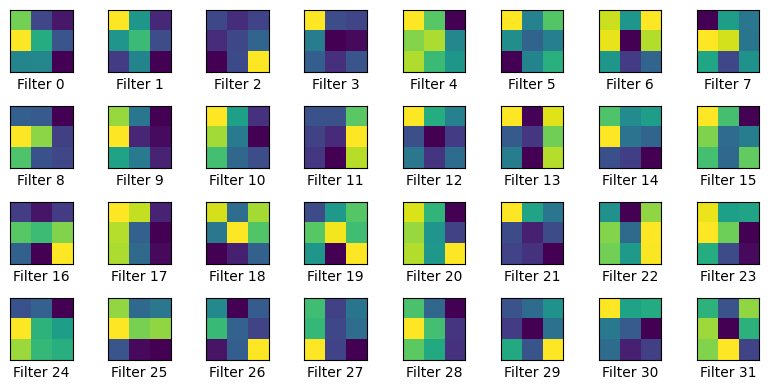

In [ ]:
print("We visualize the 5th filter in the filters of the convolutional layer {} (Layer 8)".format(aug_vgg_net[8].__class__.__name__))
visualize_filter(aug_vgg_net, layer_index=8, filter_index=5)

Now let us visualize the feature maps before and after training via feeding an image to the network.

Choose an arbitrary image from the training set.

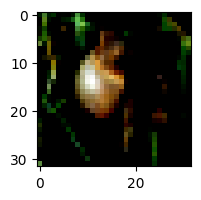

In [ ]:
plt.figure(figsize=(2, 2))
rand_img = train_set[200][0]
plt.imshow(rand_img.numpy().transpose((1,2,0)))

In [ ]:
def visualize_feature_maps(image=None, model=None, layer_to_visualize=None, n_cols=8):
    image = image[None]
    if layer_to_visualize < 0:
        layer_to_visualize += len(model)
    # Forward pass to get the features
    output = None
    name = None
    input_img = image
    for count, layer in enumerate(model):
        image = layer(image)
        if count == layer_to_visualize:
            output = image
            name = str(layer)
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])

    n_feature_maps = len(filters)  # get num_feature_maps
    n_images = n_feature_maps
    n_rows = math.ceil(n_images/n_cols)
    fig = plt.figure(figsize=(n_cols * 3, n_rows * 3))
    plt.axis("off")
    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i + 1)
        img = np.transpose(input_img.squeeze().cpu().numpy(), (1, 2, 0)) if i == 0 else filters[i].cpu().numpy()
        label = "Input image" if i == 0 else "{} of {}".format(i, n_feature_maps)
        plt.imshow(img)
        plt.xlabel(label, fontsize=10)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

<ipython-input-28-3b517ffad073>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


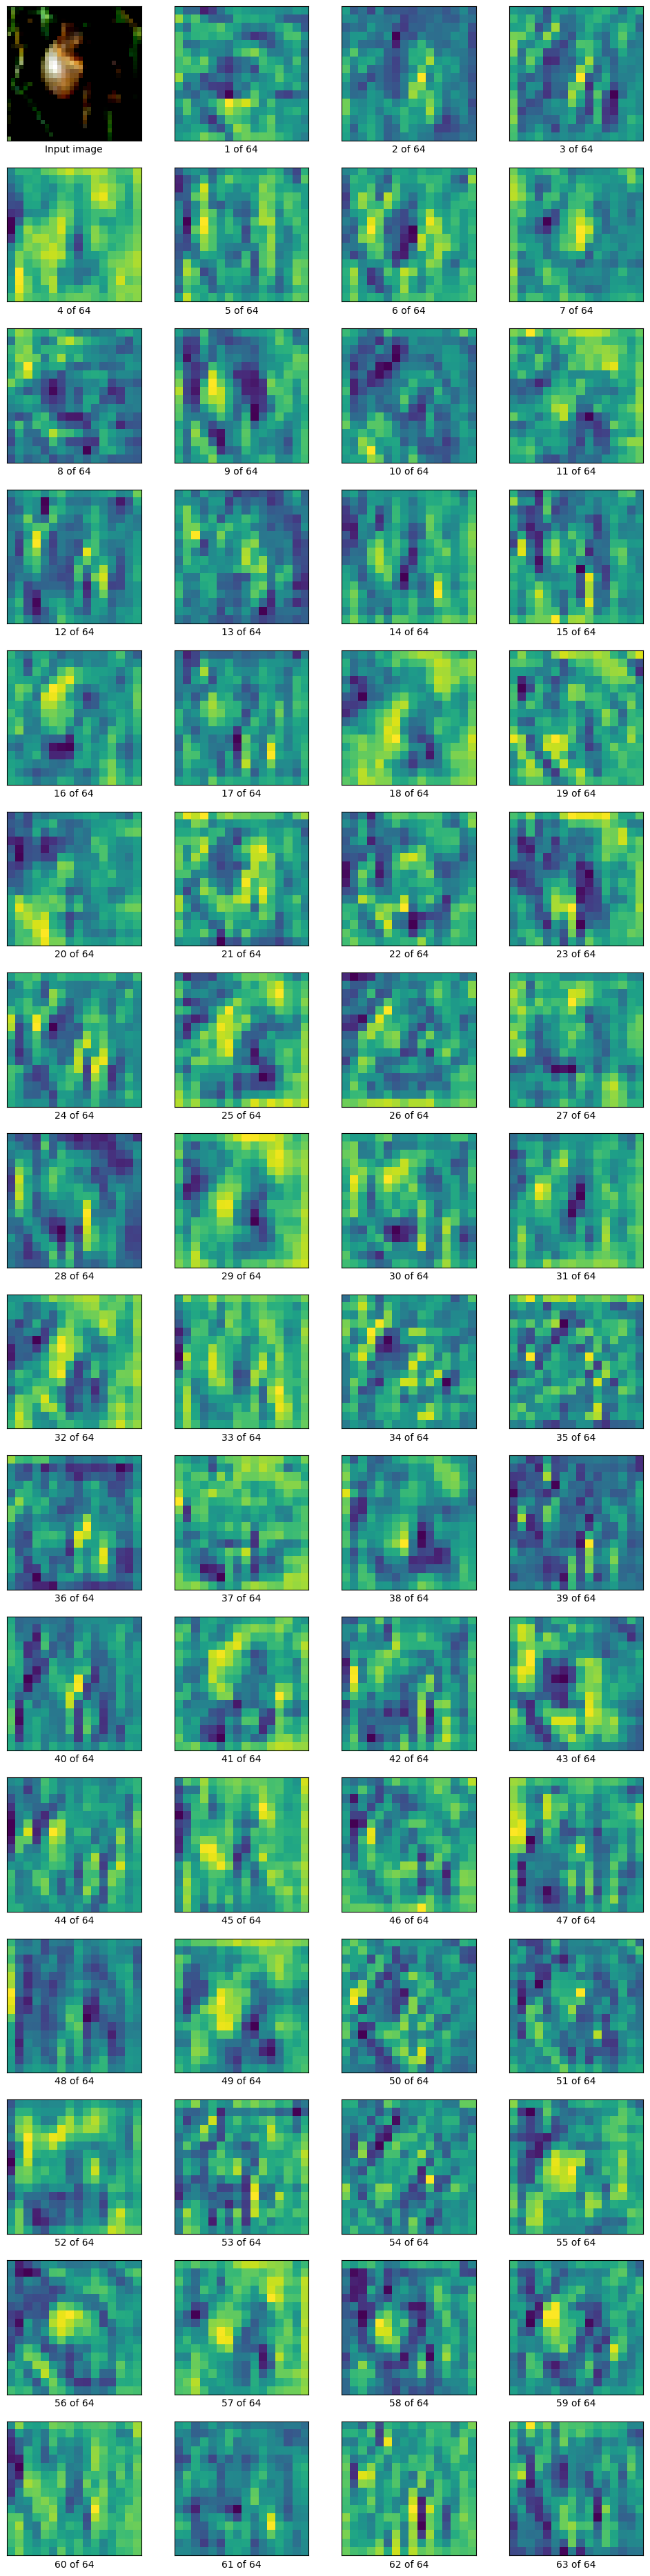

In [ ]:
aug_vgg_net.eval()
visualize_feature_maps(image=rand_img.to(device), model=aug_vgg_net, layer_to_visualize=8, n_cols=4)

**Visualizing feature maps before training**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
<ipython-input-28-3b517ffad073>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


Before the training:
Feature maps at layer ReLU.


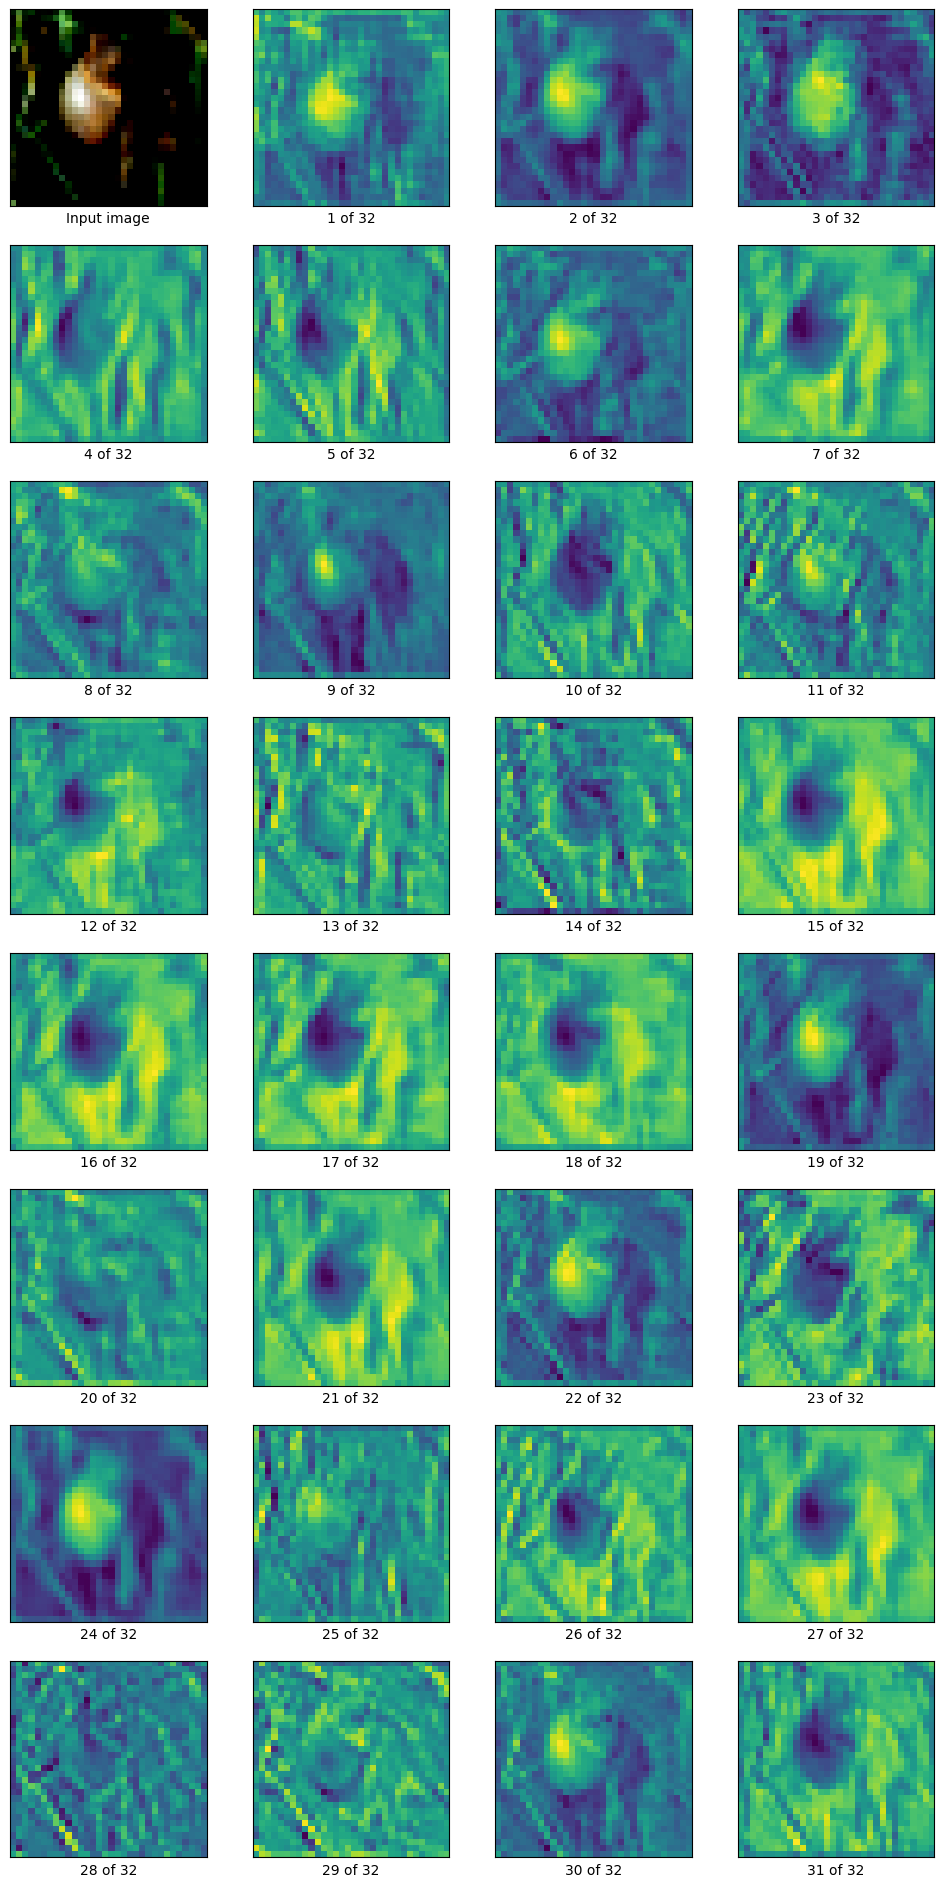

In [ ]:
vgg_init = create_vgg()
vgg_init.eval()
vgg_init = vgg_init.to(device)
print("Before the training:")
print("Feature maps at layer {}.".format(vgg_init[5].__class__.__name__))
visualize_feature_maps(image=rand_img.to(device), model=vgg_init, layer_to_visualize=0, n_cols=4)

**Visualizing feature maps after training**

<ipython-input-28-3b517ffad073>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


Feature maps at 0th layer: Conv2d.


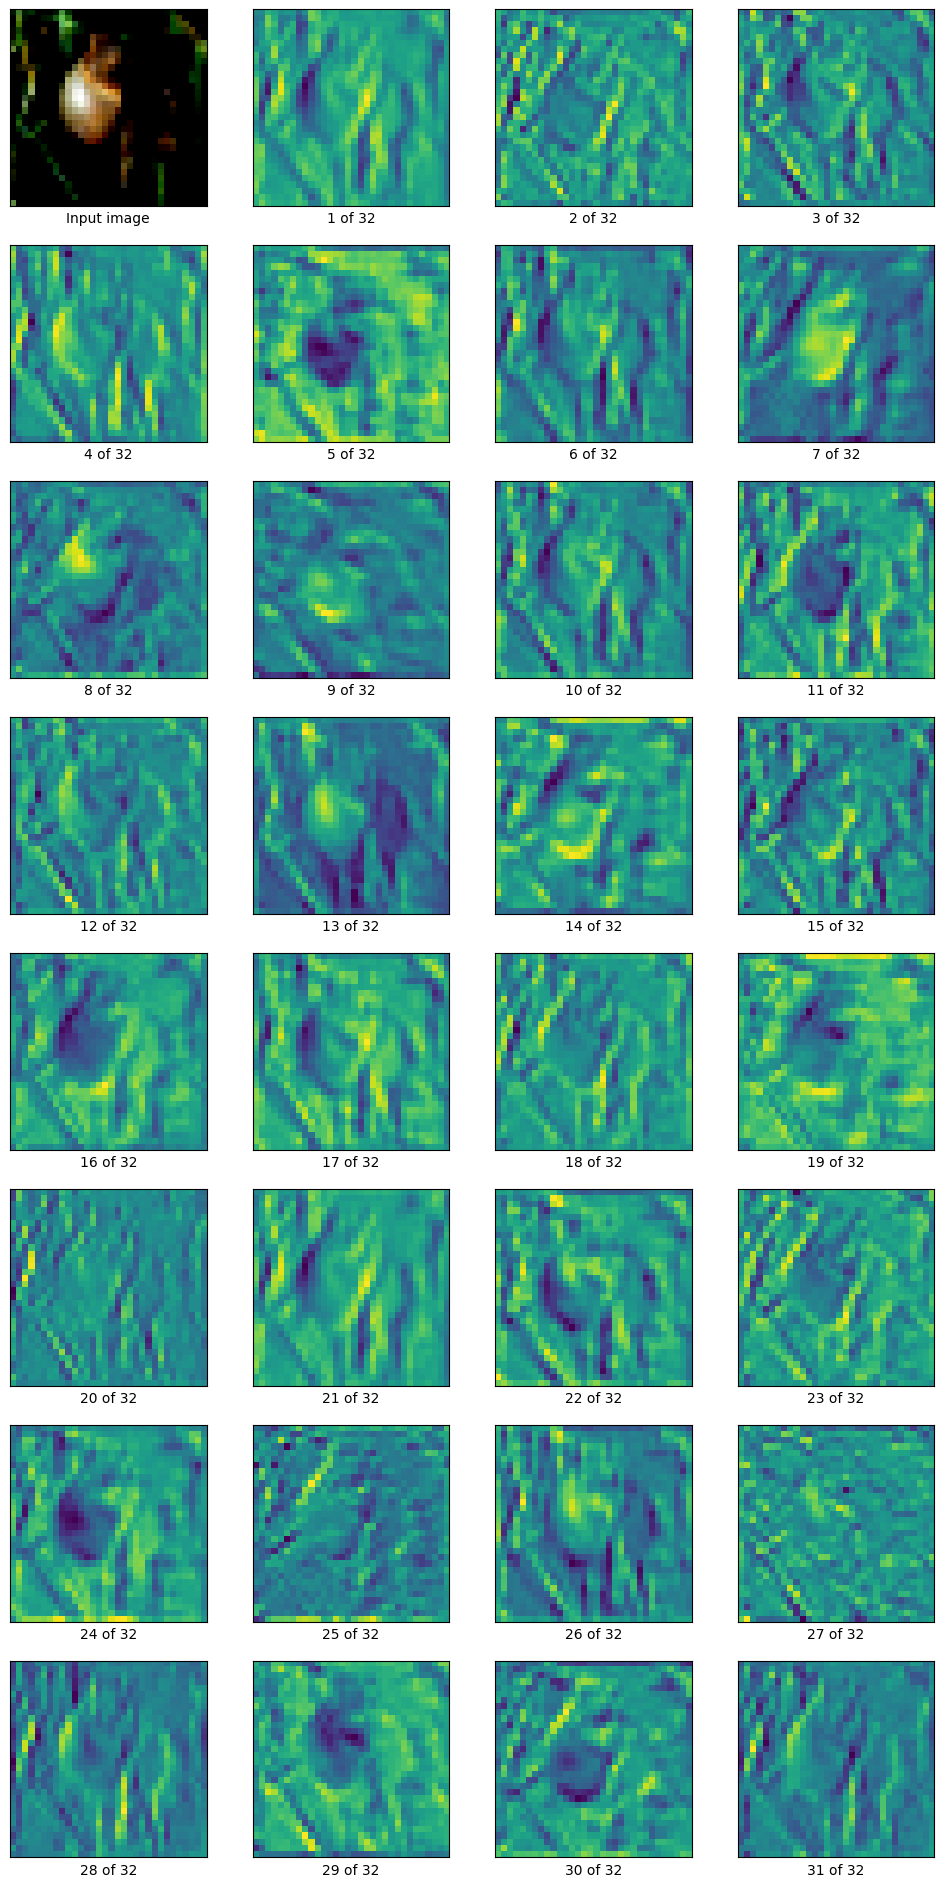

In [ ]:
print("Feature maps at 0th layer: {}.".format(vgg_init[0].__class__.__name__))
aug_vgg_net.eval()
visualize_feature_maps(image=rand_img.to(device), model=aug_vgg_net, layer_to_visualize=0, n_cols=4)

<ipython-input-28-3b517ffad073>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i + 1)


Feature maps at 2th layer: ReLU.


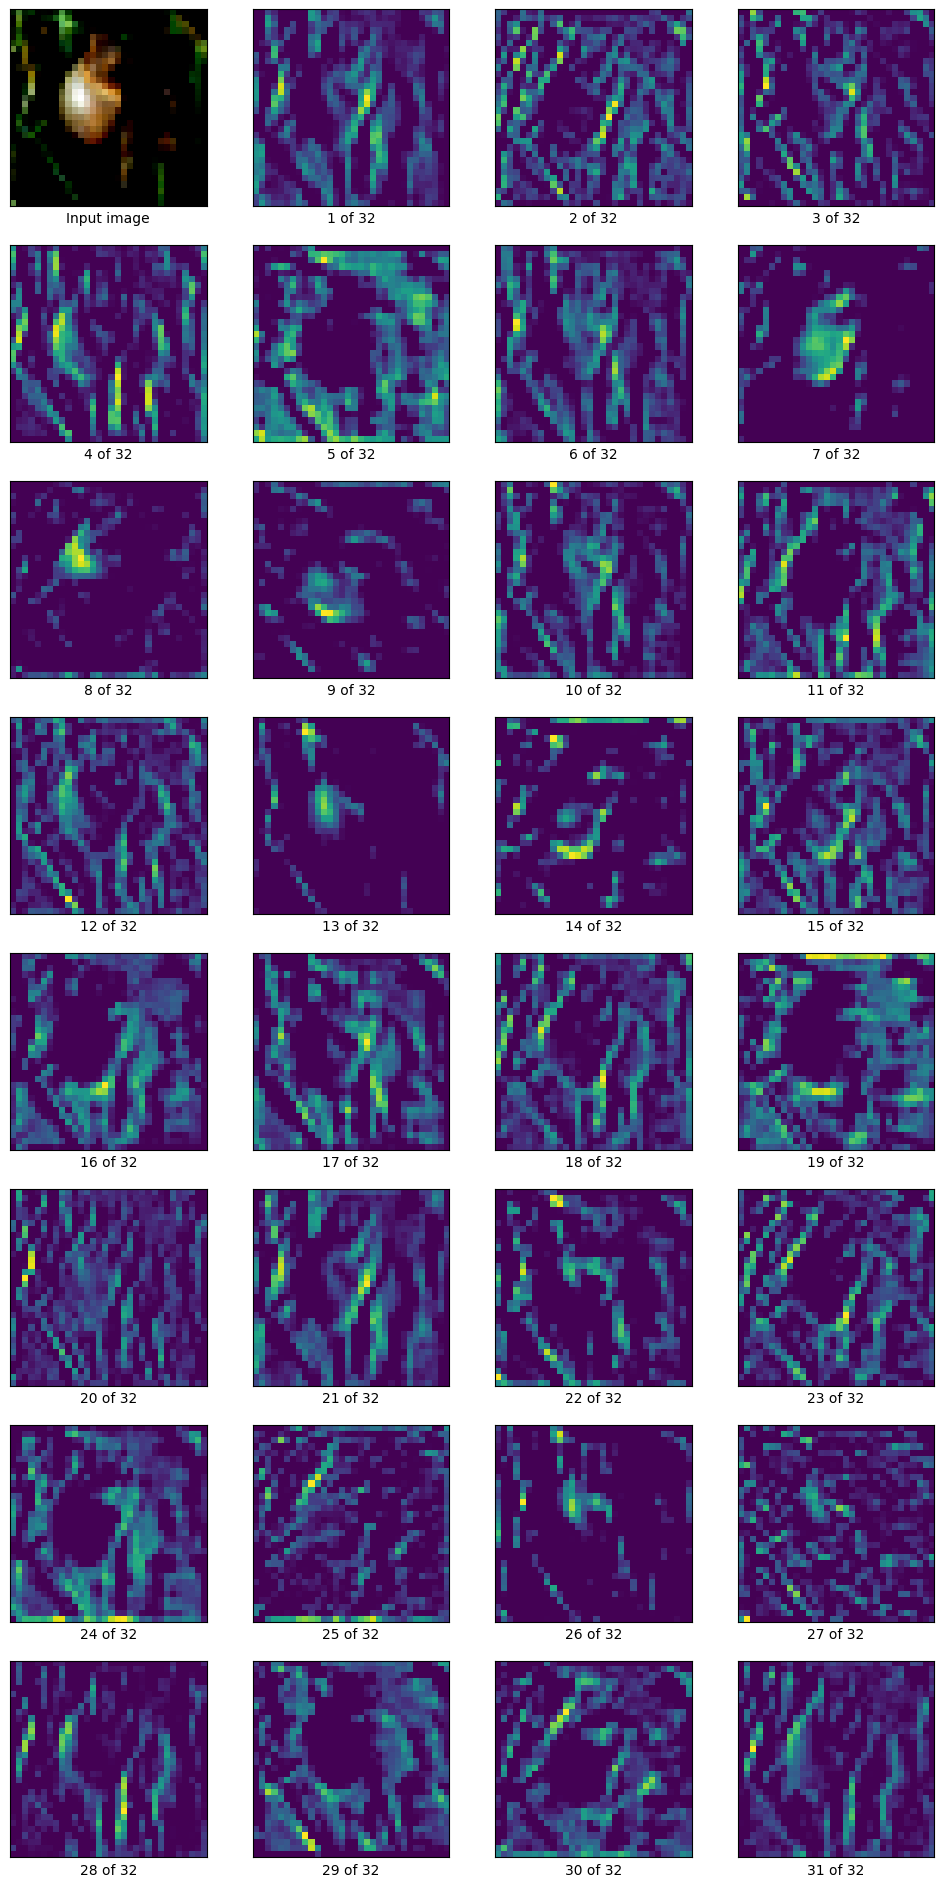

In [ ]:
print("Feature maps at 2th layer: {}.".format(vgg_init[2].__class__.__name__))
aug_vgg_net.eval()
visualize_feature_maps(image=rand_img.to(device), model=aug_vgg_net, layer_to_visualize=2, n_cols=4)

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>